## Multivariate Linear Regression

Building on our univariate linear regression model, we will take a look at the multivariate case. Our sample dataset contains housing prices for Portland, Oregon. Features consist of size (square footage) and # of bedrooms. (Note that this implementation was intended to follow along with Andrew Ng's machine learning course and the assignment guidelines may differ from what would be done in practice - in particular, foregoing the train/test split.)

In [235]:
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
def scale_features(X, means=None, stds=None):
    """Scale initial X matrix columns as (x - mean)/std."""
    if means is None and stds is None:
        means = X.mean(axis=0)
        stds = X.std(axis=0)
    X = (X - means) / stds
    return X, means, stds

In [93]:
def cost(X, y, theta):
    """Calculate adjusted MSE for given theta."""
    m = X.shape[0]
    error = y - (X @ theta)
    sse = error @ error.T
    return sse / (2 * m)

In [171]:
def gradient_descent(X, y, theta, alpha, iterations, min_improvement=0.00001):
    """Run given # of iterations of gradient descent, starting with theta as
    a zero vector, to find optimal values of theta to minimize cost.
    """
    m = X.shape[0]
    cost_vals = []
    for i in range(iterations):
        cost_vals.append(cost(X, y, theta))
        if (i > 0) and (i % 50 == 0):
            if cost_vals[-2] - cost_vals[-1] < min_improvement:
                print('Converged after {} iterations.'.format(i))
                break
        grad = -X.T @ (y - X @ theta)
        theta = theta - (alpha/m) * grad
    return theta, cost_vals

In [153]:
def scale_predict(X, theta, means, stds):
    """Pass in X as a numpy array and scale using the parameters calculated 
    on the initial dataset. Returns the predicted values using the weights 
    optimized through gradient descent.
    """
    X = scale_features(X, means, stds)[0]
    X = np.column_stack((np.ones(X.shape[0]), X))
    return X.dot(theta)

In [154]:
def normal_equation(X, y):
    """Calculate weights using normal equation."""
    t1 = np.linalg.pinv(np.dot(X.T, X))
    t2 = np.dot(X.T, y)
    return np.dot(t1, t2)

## Load Dataset

In [196]:
data_multi = np.loadtxt(r'data/ex1data2.txt', delimiter=',')

# x1 = square footage, x2 = # of bedrooms, y = sale price
X = data_multi[:,:-1]
y = data_multi[:,-1]
m, n = X.shape
print('X dimensions:', X.shape)
print('ny dimensions:', y.shape)

X dimensions: (47, 2)
ny dimensions: (47,)


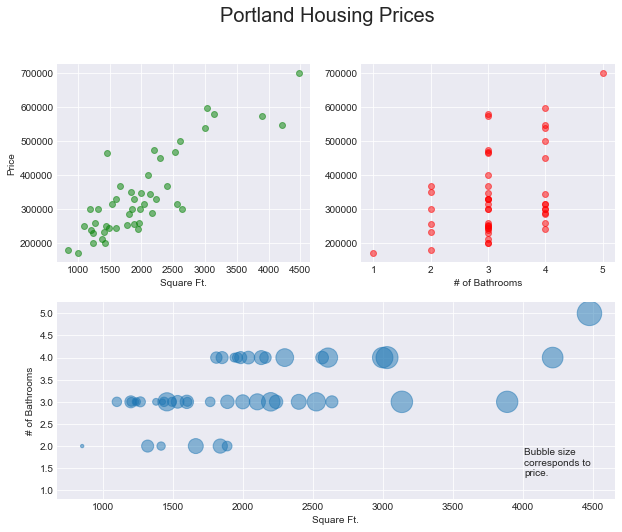

In [257]:
bubble_sizes = 600 * (y - y.min() + 1) / (y.max() - y.min())
fig = plt.figure(figsize=(10, 8), frameon=False)
grid = plt.GridSpec(2, 2, hspace=.2, wspace=.2)
plt.suptitle('Portland Housing Prices', fontsize=20)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[1, :])

# Top left.
ax0.scatter(X[:, 0], y, c='green', alpha=.5)
ax0.set_xlabel('Square Ft.')
ax0.set_ylabel('Price')

# Top right.
ax1.scatter(X[:, 1], y, c='red', alpha=.5)
ax1.set_xlabel('# of Bathrooms')

# Bottom row.
ax2.scatter(X[:,0], X[:,1], s=bubble_sizes, alpha=.5, linewidths=1)
ax2.text(4010, 1.33, 'Bubble size\ncorresponds to\nprice.')
ax2.set_xlabel('Square Ft.')
ax2.set_ylabel('# of Bathrooms')
plt.show()

## Feature Scaling

In [258]:
# Normalize features and add bias column.
X_scaled, col_means, col_stds = scale_features(X)
X_scaled = np.column_stack((np.ones(m), X_scaled))

print(f'Feature means: {col_means}')
print(f'Feature standard deviations: {col_stds}')

Feature means: [2000.68085106    3.17021277]
Feature standard deviations: [7.86202619e+02 7.52842809e-01]


## Gradient Descent

Converged after 700 iterations.
Weights: [340412.65957447 109447.7864647   -6578.34484922]


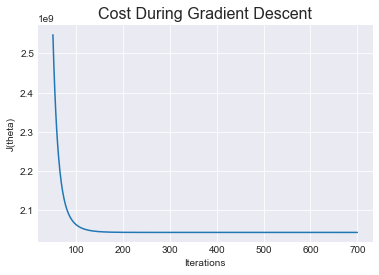

In [259]:
theta_multi = np.zeros(n+1)
alpha = 0.05
iterations = 1000

theta_m_vals, costs = gradient_descent(X_scaled, y,
                                       theta_multi,
                                       alpha, 
                                       iterations)
print('Weights:', theta_m_vals)

fig, ax = plt.subplots()
ax.plot(range(50, len(costs)), costs[50:])
plt.title('Cost During Gradient Descent', fontsize=16)
plt.xlabel('Iterations')
plt.ylabel('J(theta)')
plt.show()

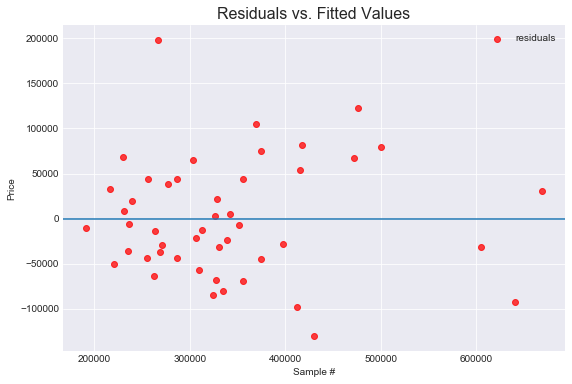

In [260]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(price_preds, y - price_preds, alpha=0.75, color='red', 
        label='residuals')
ax.axhline(y=0)
plt.title('Residuals vs. Fitted Values', fontsize=16)
plt.xlabel('Sample #')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

In [261]:
sample_house = np.array([[1650, 3]])
sample_pred = scale_predict(sample_house, theta_m_vals, col_means, col_stds)

print('Sample prediction: 1650 sq ft, 3 bedrooms:\n${}'\
      .format(np.squeeze(np.round(sample_pred, 2))))

Sample prediction: 1650 sq ft, 3 bedrooms:
$293081.47


## Normal Equation

For comparison, use the normal equation to find theta values.

In [262]:
norm_eq_theta = normal_equation(X_scaled, y)
norm_prediction = scale_predict(np.array([[1650, 3]]), norm_eq_theta,
                                col_means, col_stds)

print('Theta values from normal equation:\n{}'.format(norm_eq_theta))
print('\nSample prediction: 1650 sq feet, 3 bedrooms')
print(f'${np.squeeze(norm_prediction):.2f}')

Theta values from normal equation:
[340412.65957447 109447.79646964  -6578.35485416]

Sample prediction: 1650 sq feet, 3 bedrooms
$293081.46


# scikit-learn Implementation

For comparison, let's train a roughly equivalent model using scikit-learn. The results are slightly different due to cross validation.

In [291]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data and split into X and y dataframes.
df = pd.read_csv(r'data/ex1data2.txt', names=['square_ft','bedrooms','price'])
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [286]:
pipe = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
mses = cross_val_score(pipe, X_train, y_train, cv=3, 
                       scoring='neg_mean_squared_error')
j = -np.mean(mses)
weights_skl = [pipe.named_steps['lr'].intercept_, 
               *pipe.named_steps['lr'].coef_]
print('Weights: ' + str(weights_skl))

Weights: [334162.8, 100948.19099145211, -8181.1528738632605]


In [289]:
test_preds = pipe.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
sample_pred_skl = pipe.predict([[1650, 3]])
print('Sample prediction (1650 sq ft, 3 bathrooms): $' + 
      str(np.squeeze(sample_pred_skl)))

Sample prediction (1650 sq ft, 3 bathrooms): $289840.7259965915


Note that the use of a train/test split here yields slightly different weights and predictions.